In [2]:
import numpy as np
import scipy
import scipy.linalg
import scipy.stats
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn import linear_model
from pandas import Series, DataFrame
import pandas as pd
import sqlite3
from scipy.optimize import minimize
import pandas.io.sql as sql
from IPython.display import display_html
from decimal import Decimal
from decimal import localcontext
from scipy.integrate import quad,dblquad,nquad
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)
%matplotlib inline

Toggle Code

In [11]:
### s>>N case
G=1200
n=100
K_true=3

B_true=np.zeros((G,K_true))
for k in range(K_true):
    B_true[350*k:350*k+500,k]=1
Omega_true=np.random.normal(size=(K_true,n))
Y=B_true.dot(Omega_true)+np.random.normal(size=(G,n))

Omega_true.dot(Omega_true.T)/n

array([[ 1.07474833,  0.00708968, -0.00771694],
       [ 0.00708968,  0.97672795,  0.09556623],
       [-0.00771694,  0.09556623,  1.12269268]])

In [27]:
### s<<N case
G=1200
n=200
K_true=3

B_true=np.zeros((G,K_true))
for k in range(K_true):
    B_true[7*k:7*k+10,k]=1
Omega_true=np.random.normal(size=(K_true,n))
Y=B_true.dot(Omega_true)+np.random.normal(size=(G,n))

Omega_true.dot(Omega_true.T)/n

array([[0.9488231 , 0.02955617, 0.04018321],
       [0.02955617, 1.02884738, 0.1187478 ],
       [0.04018321, 0.1187478 , 0.97568566]])

In [28]:
database='exp15'
con=sqlite3.connect('D:\\Python Database\\FM\\'+database)
sql.to_sql(DataFrame(B_true),'B',con)
sql.to_sql(DataFrame(Omega_true),'Omega',con)
for i in range(n):
    sql.to_sql(Series(Y[:,i]),'Y'+str(i),con)

In [37]:
G=1956
n=100
K_true=5

B_true=np.zeros((G,K_true))
for k in range(K_true):
    B_true[364*k:364*k+500,k]=1
Omega_true=np.random.normal(size=(K_true,n))
Y=B_true.dot(Omega_true)+np.random.normal(size=(G,n))

Omega_true.dot(Omega_true.T)/n

array([[ 1.04509793, -0.0096046 , -0.07157508, -0.14651874, -0.13672864],
       [-0.0096046 ,  0.94648677,  0.11265326, -0.12006044,  0.0128255 ],
       [-0.07157508,  0.11265326,  1.08608395,  0.05220841, -0.0039201 ],
       [-0.14651874, -0.12006044,  0.05220841,  1.18753985,  0.04557793],
       [-0.13672864,  0.0128255 , -0.0039201 ,  0.04557793,  1.03492479]])

In [57]:
np.shape(Y)

(1956, 100)

In [58]:
database='normal_gen'
con=sqlite3.connect('D:\\Python Database\\FM\\'+database)
sql.to_sql(DataFrame(B_true),'B',con)
sql.to_sql(DataFrame(B),'B_start',con)
sql.to_sql(DataFrame(Omega_true),'Omega',con)
sql.to_sql(DataFrame(Omega_start),'Omega_start',con)
sql.to_sql(Series(Sigma),'Sigma_start',con)
for i in range(n):
    sql.to_sql(Series(Y[:,i]),'Y'+str(i),con)

In [56]:
Y=Y.T

In [39]:
K=5
#B0=np.random.normal(size=(G,K))
B0=np.zeros((G,K))
B0[:,:K_true]=B_true
Sigma0=np.ones(G)
Theta0=np.ones(K)*0.5

In [40]:
def PXL_EM_algorithm(itr=51,plot=True,l=[0,1,2,3,4,5,7,10,20,30,40,50]):
    global B,Sigma,Theta,B_heat_rec

    def reset_EM():
        global B,Sigma,Theta
    
        B=B0.copy()
        Sigma=Sigma0.copy()
        Theta=Theta0.copy()
    
        return
    
    def EM_iterate():
        global B,Sigma,Theta
        
        Sigma_inv=scipy.diag(1/Sigma)
        M=scipy.linalg.inv(scipy.eye(K)+(((B.T).dot(Sigma_inv)).dot(B)))
        M_L=scipy.linalg.cholesky(M, lower=True)
        E_Omega=((Y.dot(Sigma_inv)).dot(B)).dot(M)
        E_Gamma=scipy.zeros((G,K))
        for j in range(G):
            for k in range(K):
                E_Gamma[j,k]=1/(1+(l0*(1-Theta[k]))/(l1*Theta[k])*np.exp(-abs(B[j,k])*(l0-l1)))
        tilde_Y=np.vstack((Y,scipy.zeros((K,G))))
        tilde_Omega=np.vstack((E_Omega,np.sqrt(n)*M_L))
        B_=scipy.zeros((G,K))
        for j in range(G):
            lambda_j=l1*E_Gamma[j]+l0*(1-E_Gamma[j])
            clf = linear_model.Lasso(alpha=Sigma[j]/(n+k),fit_intercept=False)
            clf.fit(tilde_Omega/lambda_j, tilde_Y[:,j])
            B_[j]=clf.coef_/lambda_j     
            Sigma[j]=(np.linalg.norm(tilde_Y[:,j]-tilde_Omega.dot(B_[j]))**2+1)/(n+1)
        for k in range(K):
            a=sum(E_Gamma[:,k])
            b=G-a
            if k==K-1:
                a+=alpha-1
            Theta[k]=max(a/(a+b),0.00001)    
        arg=np.argsort(-Theta)
        Theta=Theta[arg]
        B=B_[:,arg]
        
        return
    
    def PXL_EM_iterate():
        global B,Sigma,Theta,A
        
        Sigma_inv=scipy.diag(1/Sigma)
        M=scipy.linalg.inv(scipy.eye(K)+(((B.T).dot(Sigma_inv)).dot(B)))
        M_L=scipy.linalg.cholesky(M, lower=True)
        E_Omega=((Y.dot(Sigma_inv)).dot(B)).dot(M)
        E_Gamma=scipy.zeros((G,K))
        for j in range(G):
            for k in range(K):
                E_Gamma[j,k]=1/(1+(l0*(1-Theta[k]))/(l1*Theta[k])*np.exp(-abs(B[j,k])*(l0-l1)))
        tilde_Y=np.vstack((Y,scipy.zeros((K,G))))
        tilde_Omega=np.vstack((E_Omega,np.sqrt(n)*M_L))
        B_=scipy.zeros((G,K))
        for j in range(G):
            lambda_j=l1*E_Gamma[j]+l0*(1-E_Gamma[j])
            clf = linear_model.Lasso(alpha=Sigma[j]/(n+k),fit_intercept=False,tol=0.000001)
            clf.fit(tilde_Omega/lambda_j, tilde_Y[:,j])
            B_[j]=clf.coef_/lambda_j     
            Sigma[j]=(np.linalg.norm(tilde_Y[:,j]-tilde_Omega.dot(B_[j]))**2+1)/(n+1)
        A=(E_Omega.T).dot(E_Omega)/n+M
        for k in range(K):
            a=sum(E_Gamma[:,k])
            b=G-a
            if k==K-1:
                a+=alpha-1
            Theta[k]=max(a/(a+b),0.00001)    
        arg=np.argsort(-Theta)
        Theta=Theta[arg]
        B=(B_.dot(scipy.linalg.cholesky(A, lower=True)))[:,arg]
        #B=(B_[:,arg]).dot(scipy.linalg.cholesky(A, lower=True))
        
        return
    
    #main
    reset_EM()
    if plot:
        fig,ax=plt.subplots(1,len(l)+1)
        fig.set_size_inches(16, 5)
    (ax[0]).imshow(-abs(B_true), cmap=plt.cm.gray,aspect='auto',interpolation='bilinear')
    (ax[0]).set_title('B_true')
    c=1
    for i in range(itr):
        print(i)
        if plot:
            if i in l:
                (ax[c]).imshow(-abs(B), cmap=plt.cm.gray,aspect='auto',interpolation='bilinear')
                (ax[c]).set_title('itr='+str(i))
                c+=1
            if i in [0,5,10,15,25,50]:
                B_heat_rec.append(B.copy())
        PXL_EM_iterate()
        
    B_recover_PXL_EM=B.copy()
        
    return

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


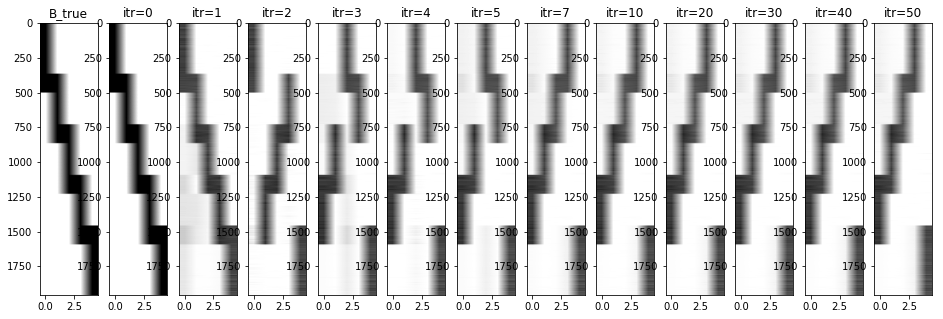

In [41]:
B_heat_rec=[]
l1=0.001;l0=20;nu=1;epsilon=1;alpha=1/G
PXL_EM_algorithm()

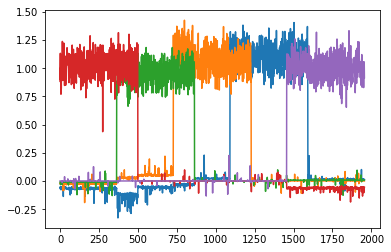

In [42]:
plt.plot(B)

In [45]:
Omega_start=np.linalg.solve(B.T.dot(B),B.T.dot(Y.T))